This notebook introduces the problem addressed in this paper:

 - localizating an object in a large image
 - foveation
 - action (saccade)
 

In [1]:
figname = '../paper/fig_crowding'

In [2]:
%run 0_parameters.ipynb


This notebook introduces the problem addressed in this paper:

 - localizating an object in a large image
 - foveation
 - action (saccade)
       
      
{'w': 28, 'minibatch_size': 100, 'train_batch_size': 50000, 'test_batch_size': 10000, 'noise_batch_size': 1000, 'mean': 0.1307, 'std': 0.3081, 'N_pic': 128, 'offset_std': 15, 'offset_max': 30, 'noise': 1.0, 'contrast': 0.3, 'sf_0': 0.2, 'B_sf': 0.3, 'N_theta': 6, 'N_azimuth': 16, 'N_eccentricity': 8, 'N_phase': 2, 'rho': 1.41, 'bias_deconv': True, 'p_dropout': 0.0, 'dim1': 500, 'dim2': 2000, 'lr': 0.001, 'do_adam': True, 'bn1_bn_momentum': 0.5, 'bn2_bn_momentum': 0.2, 'momentum': 0.1, 'epochs': 25, 'num_processes': 1, 'no_cuda': True, 'log_interval': 100, 'verbose': 1, 'filename': '../data/2019-03-28', 'seed': 2019, 'N_cv': 8, 'do_compute': True}
Overwriting train.py
2019-04-02T15:51:04+02:00

CPython 3.7.3rc1
IPython 7.4.0

numpy 1.16.2
matplotlib 3.0.2
torch 1.0.1.post2

compiler   : GCC 8.3.0
system     : Linux
release    : 4.19.0

# Training the WhatWhere network

In [3]:
%ls -lh ../data/*pt

-rw-r--r-- 1 dauce dauce 6,9M mars  28 08:04 ../data/2019-03-27_train.pt
-rw-r--r-- 1 dauce dauce 6,9M mars  28 20:40 ../data/2019-03-28_train.pt


In [4]:
%ls -lh ../data/*npy

-rw-r--r-- 1 dauce dauce 800 mars  14 14:37 ../data/2019-02-13-add-crowding-test-continued-result.npy
-rw-r--r-- 1 dauce dauce 880 mars  14 14:37 ../data/2019-02-13-add-crowding-test-result.npy
-rw-r--r-- 1 dauce dauce 12M mars   3 08:18 ../data/2019-03-07_CNS.npy
-rw-r--r-- 1 dauce dauce 17K avril  1 23:06 ../data/2019-03-29-crowding-result.npy
-rw-r--r-- 1 dauce dauce 481 mars  29 15:13 ../data/2019-03-29-crowding-test-result.npy
-rw-r--r-- 1 dauce dauce 24K sept.  7  2018 ../data/MNIST_accuracy.npy


In [7]:
from main_orig import init
#args = init(filename='debug')
args = init(filename='../data/2019-03-28')
from whatWhere import WhatWhere
whatWhere = WhatWhere(args, save = True)
print('starting training...')
filename_train = args.filename + '_train.pt'
#filename_train = "../data/2019-03-14_train4.pt"
#filename_train = "../data/2019-03-15_train_b.pt"
%ls -lh {filename_train}
#%rm {filename_train}
#%rm  ../data/debug_train.pt

whatWhere.train(filename_train)

1
2
3
starting training...
-rw-r--r-- 1 dauce dauce 6,9M mars  28 20:40 ../data/2019-03-28_train.pt
Loading file ../data/2019-03-28_train.pt


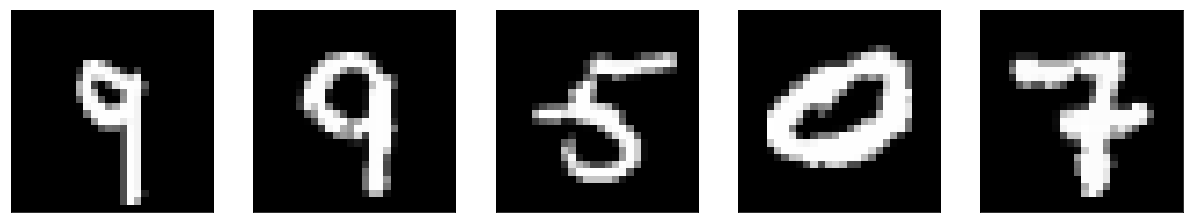

In [5]:
data_d, label_d = next(iter(whatWhere.display.loader_test))
N_plot = 5
fig, axs = plt.subplots(1, N_plot, figsize = (21, 5))
for i_ax, ax in enumerate(axs):
    ax.imshow(data_d[i_ax+5, 0, :, :], cmap=plt.gray())
    ax.set_xticks([])
    ax.set_yticks([])

13
21
14


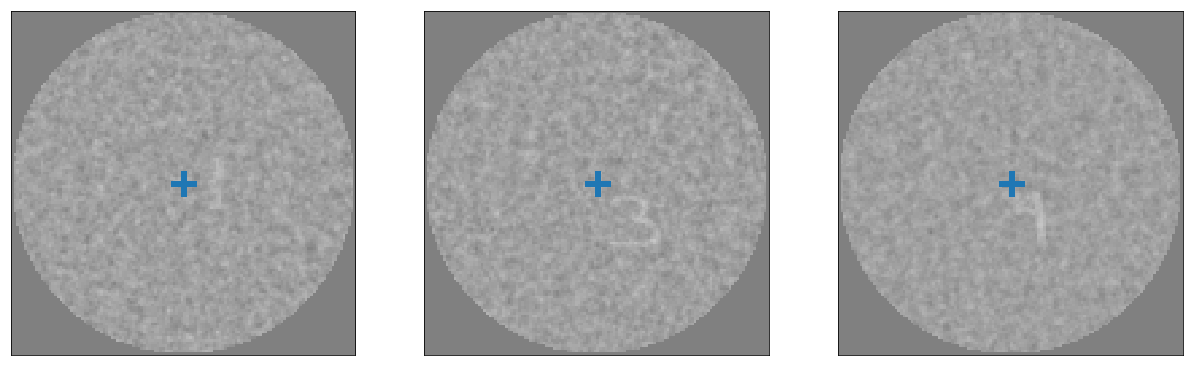

In [16]:
N_plot = 3
fig, axs = plt.subplots(1, N_plot, figsize = (21, 8))
for i_ax, ax in enumerate(axs):
    data_fullfield, i_offset, j_offset = whatWhere.display.draw(data_d[i_ax, 0, :, :].numpy())
    ax = whatWhere.display.show(ax, data_fullfield)


In [10]:
data, label = next(iter(whatWhere.loader_train)) 
print(data.shape)
print(label.shape)
pred = whatWhere.model.forward(data).argmax(dim=1, keepdim=True)
print(pred.eq(label.view_as(pred)).sum())
print(whatWhere.pred_accuracy(data, label)) #/whatWhere.args.minibatch_size)


torch.Size([100, 1536])
torch.Size([100])
tensor(82)
0.82


In [22]:
data, label = next(iter(whatWhere.loader_test)) 
print(data.shape)
print(label.shape)
pred = whatWhere.model.forward(data).argmax(dim=1, keepdim=True)
print(pred.eq(label.view_as(pred)).sum())
print(whatWhere.pred_accuracy(data, label))


torch.Size([10000, 1536])
torch.Size([10000])
tensor(8244)
0.8244


AxesSubplot(0.125,0.125;0.168478x0.755)
7
tensor([7])
AxesSubplot(0.327174,0.125;0.168478x0.755)
5
tensor([5])
AxesSubplot(0.529348,0.125;0.168478x0.755)
2
tensor([2])
AxesSubplot(0.731522,0.125;0.168478x0.755)
6
tensor([6])


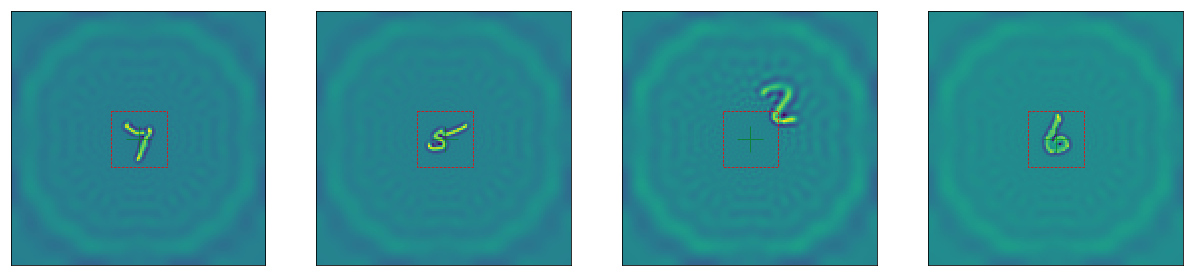

In [28]:
N_plot = 8
fig, axs = plt.subplots(1, 4, figsize = (21, 8))
for i_ax, ax in enumerate(axs):
    num = i_ax+20
    data_fullfield = whatWhere.retina.retina_invert(data[num,:].numpy())
    ax = whatWhere.retina.show(ax, data_fullfield)
    print(ax)
    print(label[num].numpy()) #ax.title(label[i_ax].numpy())
    print(pred[num]) #ax.title(label[i_ax].numpy())

In [14]:
FIC_NAME = '../data/2019-03-29-crowding-test'
result = {}

for period in range(1,21):
    args.sf_0 = 1/period
    result[period] = {} 
    for prop in np.arange(0.25,2.25,0.25):
        args.B_sf = prop/period
        whatWhere = WhatWhere(args, save = False)
        whatWhere.train()
        data_test, label_test = next(iter(whatWhere.loader_test)) 
        acc = whatWhere.pred_accuracy(data_test, label_test)
        print(f'sf_0 : {args.sf_0}, B_sf : {args.B_sf}, acc : {acc}')
        result[period][prop] = acc
        np.save(FIC_NAME + '-result.npy', result)
    

1
2
3
Creating training dataset
train dataset, size =  50000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
Done!
Creating testing dataset
test dataset, size =  10000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000


Train Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Done!


Train Epoch: 100%|██████████| 25/25 [10:33<00:00, 24.82s/it]


TypeError: list indices must be integers or slices, not numpy.float64

In [19]:
print(f'sf_0 : {args.sf_0}, B_sf : {args.B_sf}, acc : {acc}')

sf_0 : 1.0, B_sf : 0.25, acc : 0.8244


In [29]:
result[period] = {} 

In [30]:
result[period][prop] = acc

In [33]:
FIC_NAME = '../data/2019-03-29-crowding-test'
np.save(FIC_NAME + '-result.npy', result)

In [34]:
res = np.load(FIC_NAME + '-result.npy')
print(res)

{1: {0.25: 0.8244}}


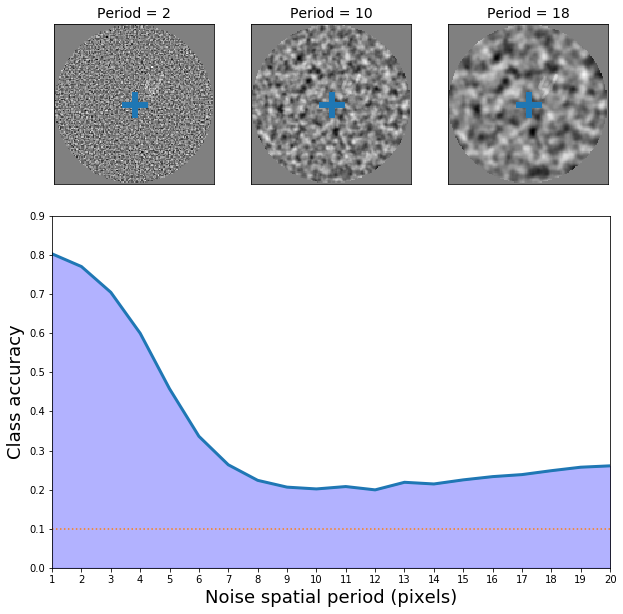

In [58]:
from retina import Display


FIC_NAME = '../data/2019-03-29-crowding-result.npy'
res = np.load(FIC_NAME).tolist()
shape = len(res), len(res[1])
im = np.zeros(shape)
for i, period in enumerate(range(1,21)):
    for j, prop in enumerate(np.arange(0.25,2.25,0.25)):
        im[i, j] = res[period][prop]

fig = plt.figure(figsize = (10,10))

period = 2
args.sf_0 = 1/period
args.B_sf = 1/period
ax = fig.add_subplot(3, 3, 1)
ax.set_title(f'Period = {period}', fontsize = 14)
display = Display(args, save = False)
data, _ = next(iter(display.loader_test))
data_fullfield, i_offset, j_offset = display.draw(data[4, 0, :, :].numpy(), i_offset=-15, j_offset=15)
ax = display.show(ax, data_fullfield)

period = 10
args.sf_0 = 1/period
args.B_sf = 1/period
ax = fig.add_subplot(3, 3, 2)
ax.set_title(f'Period = {period}', fontsize = 14)
display = Display(args, save = False)
data_fullfield, i_offset, j_offset = display.draw(data[4, 0, :, :].numpy(), i_offset=-15, j_offset=15)
ax = display.show(ax, data_fullfield)

period = 18
args.sf_0 = 1/period
args.B_sf = 1/period
ax = fig.add_subplot(3, 3, 3)
ax.set_title(f'Period = {period}', fontsize = 14)
display = Display(args, save = False)
data_fullfield, i_offset, j_offset = display.draw(data[4, 0, :, :].numpy(), i_offset=-15, j_offset=15)
ax = display.show(ax, data_fullfield)

ax = fig.add_subplot(3, 1, (2,3))
ax.fill_between(range(1,21), im[:,3], color = 'b', alpha = .3)
ax.plot(range(1,21), im[:,3], linewidth = 3)
_ = ax.set_xticks(range(1,21))
_ = ax.set_xlabel('Noise spatial period (pixels)', fontsize = 18)
_ = ax.set_xlim([1, 20])
_ = ax.set_ylabel('Class accuracy', fontsize = 18)
_ = ax.set_ylim([0, 0.9])
_ = ax.plot([1, 20],[0.1, 0.1], ':')


In [59]:
args

{'w': 28,
 'minibatch_size': 100,
 'train_batch_size': 50000,
 'test_batch_size': 10000,
 'noise_batch_size': 1000,
 'mean': 0.1307,
 'std': 0.3081,
 'N_pic': 128,
 'offset_std': 15,
 'offset_max': 30,
 'noise': 1.0,
 'contrast': 0.3,
 'sf_0': 0.05555555555555555,
 'B_sf': 0.05555555555555555,
 'N_theta': 6,
 'N_azimuth': 16,
 'N_eccentricity': 8,
 'N_phase': 2,
 'rho': 1.41,
 'bias_deconv': True,
 'p_dropout': 0.0,
 'dim1': 500,
 'dim2': 2000,
 'lr': 0.001,
 'do_adam': True,
 'bn1_bn_momentum': 0.5,
 'bn2_bn_momentum': 0.2,
 'momentum': 0.1,
 'epochs': 25,
 'num_processes': 1,
 'no_cuda': True,
 'log_interval': 100,
 'verbose': 1,
 'filename': '../data/2019-03-28',
 'seed': 2019,
 'N_cv': 8,
 'do_compute': True}